# Photoacoustics with LDV - Data Analysis 

In [1]:
# load data for differnt concentrion

import h5py
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal



hf = h5py.File('data.h5','r')
print(list(hf.keys()))


['IQ', 'concentrations', 'scans']


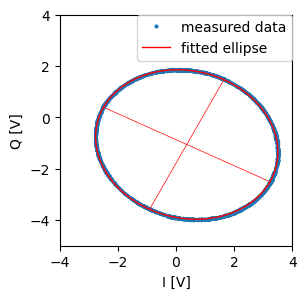

In [2]:
I_data = hf['IQ/data_Q']
Q_data = hf['IQ/data_I']

a = hf['IQ/fitted_ellipse/a'][0]
b = hf['IQ/fitted_ellipse/b'][0]
x0 = hf['IQ/fitted_ellipse/X0'][0]
y0 = hf['IQ/fitted_ellipse/Y0'][0]
phi = hf['IQ/fitted_ellipse/phi'][0]
x0_in = hf['IQ/fitted_ellipse/X0_in'][0]
y0_in = hf['IQ/fitted_ellipse/Y0_in'][0]
long_axis = hf['IQ/fitted_ellipse/long_axis'][0]
short_axis = hf['IQ/fitted_ellipse/short_axis'][0]



from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
# Calculate the endpoints of the major and minor axes
major_axis_end1 = (y0_in + long_axis/2 * np.cos(phi), x0_in + long_axis/2 * np.sin(phi))
major_axis_end2 = (y0_in - long_axis/2 * np.cos(phi), x0_in - long_axis/2 * np.sin(phi))
minor_axis_end1 = (y0_in + short_axis/2 * np.sin(phi), x0_in - short_axis/2 * np.cos(phi))
minor_axis_end2 = (y0_in - short_axis/2 * np.sin(phi), x0_in + short_axis/2 * np.cos(phi))

# scatter plot of I and Q data
fig, ax = plt.subplots(figsize=(3,3))
plt.scatter(I_data,Q_data, s=0.1)

# Create an ellipse with the fitted parameters
ellipse = Ellipse((y0_in,x0_in), width=long_axis, height=short_axis, angle=np.degrees(phi), fill=False, edgecolor='r', linewidth=1)

# Add the ellipse to the plot
ax.add_patch(ellipse)

# Add lines for the major and minor axes
plt.plot(*zip(major_axis_end1, major_axis_end2), 'r-', linewidth=0.5)
plt.plot(*zip(minor_axis_end1, minor_axis_end2), 'r-', linewidth=0.5)
plt.xlim(-4,4)
plt.ylim(-5,3)
plt.xlabel('I [V]')
plt.ylabel('Q [V]')
plt.xticks([-4,-2,0,2,4])
plt.yticks([-4,-2,0,2,4])
#plt.legend(['measured data','fitted ellipse'])


# Create custom legend handles
measured_data_handle = Line2D([0], [0], marker='o', color='None', markerfacecolor='tab:blue', markeredgecolor='tab:blue', markersize=2)
fitted_ellipse_handle = Line2D([0], [0], color='r', linewidth=1)

# Add the legend with the custom handles
plt.legend(handles=[measured_data_handle, fitted_ellipse_handle], labels=['measured data', 'fitted ellipse'], bbox_to_anchor=(1.03, 1.03))

plt.show()
plt.show()

# save as pdf
fig.savefig('ellipse.pdf', bbox_inches='tight')


In [3]:
concentration0 = hf['concentrations/pdms_middle_10s_500ns_1pld_0pcm_velocity']
concentration1 = hf['concentrations/pdms_middle_10s_500ns_1pld_10pcm_velocity']
concentration2 = hf['concentrations/pdms_middle_10s_500ns_1pld_25pcm_velocity']
concentration3 = hf['concentrations/pdms_middle_10s_500ns_1pld_50pcm_velocity']
concentration4 = hf['concentrations/pdms_middle_10s_500ns_1pld_100pcm_velocity']
concentration5 = hf['concentrations/pdms_middle_10s_500ns_1pld_250pcm_velocity']
concentration6 = hf['concentrations/pdms_middle_10s_500ns_1pld_500pcm_velocity']
concentration7 = hf['concentrations/pdms_middle_10s_500ns_1pld_1000pcm_velocity']

c0 = np.squeeze(np.array(concentration0))
c1 = np.squeeze(np.array(concentration1))
c2 = np.squeeze(np.array(concentration2))
c3 = np.squeeze(np.array(concentration3))
c4 = np.squeeze(np.array(concentration4))
c5 = np.squeeze(np.array(concentration5))
c6 = np.squeeze(np.array(concentration6))
c7 = np.squeeze(np.array(concentration7))


In [4]:
# data processing and filtering
pretrig = 248
fs = 65e6
time = np.linspace(-pretrig/fs, (len(c0)-pretrig)/fs, len(c0))*1e6

# function for applying butterworth filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b,a,data)
    return y

concentration_data = np.array([c0, c1, c2, c3, c4, c5, c6, c7])
concentration_data.shape
# apply filter  each concentration

filtered_data = np.zeros((8, len(c0)))
for i in range(8):
    filtered_data[i] = butter_lowpass_filter(concentration_data[i], 5e6, fs, order=5)

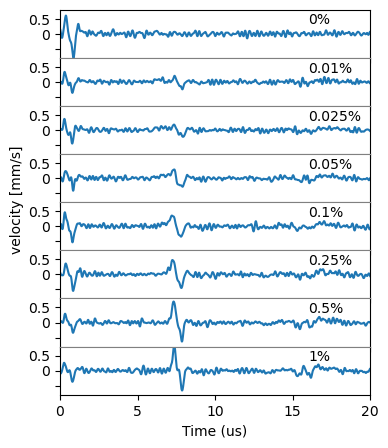

In [5]:
fig = plt.figure(figsize=(4,5))
gs = fig.add_gridspec(8,1, hspace=0)
ax = gs.subplots(sharex=True)

concentration_labels = ['0', '0.01', '0.025', '0.05', '0.1', '0.25', '0.5', '1']
for i in range(8):
    ax[i].plot(time, filtered_data[i]*1e3)
    ax[i].set_ylim(-0.8, 0.8)
    ax[i].set_xlim(0, 20)
    # change color of bottom and top boundary to grey except for bottom plot
    if i != 7:
        ax[i].spines['bottom'].set_color('grey')
    if i != 0:
        ax[i].spines['top'].set_color('grey')
    # show only 0 and 0.5 on ylabels
    ax[i].set_yticks([-0.5, 0, 0.5], ['',0,0.5])
    # put in every plot the concentration
    ax[i].text(0.8, 0.7, concentration_labels[i]+'%', transform=ax[i].transAxes)
    
ax[7].set_xlabel('Time (us)')
# create a global y label
fig.text(0.0, 0.5, 'velocity [mm/s]', va='center', rotation='vertical')


plt.show()
# save as pdf
fig.savefig('concentrations.pdf', bbox_inches='tight')


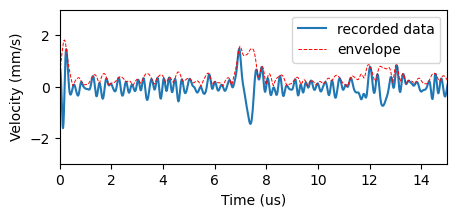

In [6]:
time = np.linspace(-pretrig/fs, (len(c0)-pretrig)/fs, len(c0))*1e6
scan_data = hf['scans/pdms_middle_1s_10mm_125umstep_1000pcm_velocity']

pretrig = 540


# Apply the filter to each time series in scan_data
filtered_data = np.empty(scan_data.shape)
for i in range(scan_data.shape[0]):
    filtered_data[i, :] = butter_lowpass_filter(scan_data[i, :]*1e3, 5e6, fs, order=5)


time = np.linspace(-pretrig/fs, (len(filtered_data[1,:])-pretrig)/fs, len(filtered_data[1,:]))*1e6

#pretrig = 256

# Slice the time and filtered_data arrays
time = time[pretrig:1600]
filtered_data = filtered_data[:, pretrig:1600]
# calculate hilbert transform for each row
hilbert_data = np.empty(filtered_data.shape, dtype=np.complex_)
for i in range(filtered_data.shape[0]):
    hilbert_data[i,:] = signal.hilbert(filtered_data[i,:])

row = 32
# plot data from row 30 of filtered data
fig = plt.figure(figsize=(5,2))
plt.plot(time, filtered_data[row,:])
plt.plot(time, np.abs(hilbert_data[row,:]),'r--', linewidth=0.7)
plt.ylim(-3,3)
plt.xlim(0,15)
plt.xlabel('Time (us)')
plt.ylabel('Velocity (mm/s)')
plt.legend(['recorded data', 'envelope'])
fig.savefig('measuredsignal.pdf', bbox_inches='tight')



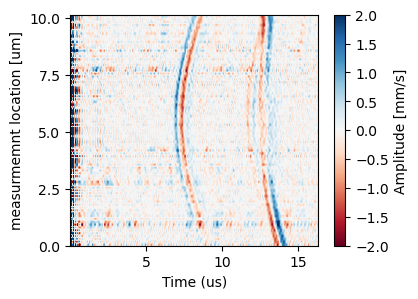

In [7]:

# Define the bounds
left = time[0]
right = time[-1]
bottom = 0
top = filtered_data.shape[0]  # assuming the y-axis should be the index of the time series

# Make a 2d plot of the filtered data
fig, ax = plt.subplots(figsize=(4,3))
plt.imshow(filtered_data, aspect='auto', cmap='RdBu', vmin=-2, vmax=2, extent=[left, right, bottom, top])
plt.colorbar(label='Amplitude [mm/s]')
y_ticks = ax.get_yticks()
plt.yticks(y_ticks, y_ticks * 0.125)
plt.ylim(0,81)
plt.xlabel('Time (us)')
plt.ylabel('measurmemnt location [um]')
plt.show()


# save as pdf
fig.savefig('scan_1.pdf', bbox_inches='tight')

# the data in this file is processed using matlabs kwave toolbox with the script    ....m


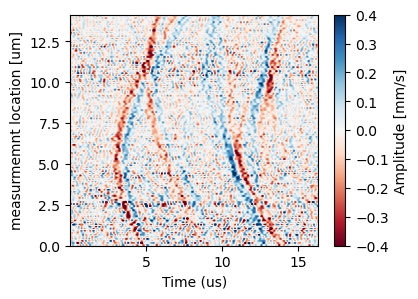

In [16]:
dualchannel_scan_data = hf['scans/dualchannel_1s_500ns_flipped_1Vp_14mm_125umstep']
pretrig = 540

# Apply the filter to each time series in scan_data
filtered_data = np.empty(dualchannel_scan_data.shape)
for i in range(dualchannel_scan_data.shape[0]):
    filtered_data[i, :] = butter_lowpass_filter(dualchannel_scan_data[i, :]*1e3, 3e6, fs, order=5)

time = np.linspace(-pretrig/fs, (len(filtered_data[1,:])-pretrig)/fs, len(filtered_data[1,:]))*1e6
#pretrig = 256
# Slice the time and filtered_data arrays
time = time[pretrig:1600]
filtered_data = filtered_data[:, pretrig:1600]

# Define the bounds
left = time[0]
right = time[-1]
bottom = 0
top = filtered_data.shape[0]  # assuming the y-axis should be the index of the time series

# Make a 2d plot of the filtered data
fig, ax = plt.subplots(figsize=(4,3))
plt.imshow(filtered_data, aspect='auto', cmap='RdBu', vmin=-.4, vmax=.4, extent=[left, right, bottom, top])
plt.colorbar(label='Amplitude [mm/s]')
y_ticks = ax.get_yticks()
plt.yticks(y_ticks, y_ticks * 0.125)
plt.ylim(0,113)
plt.xlabel('Time (us)')
plt.ylabel('measurmemnt location [um]')
plt.show()


# save as pdf
fig.savefig('scan_dualchannel.pdf', bbox_inches='tight')

# the data in this file is processed using matlabs kwave toolbox with the script    ....m